In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
# from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import numpy as np

In [2]:
class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, feature_g):
        super(Generator, self).__init__()
        self.conv = nn.Sequential(
            nn.ConvTranspose2d(channels_noise, feature_g*16, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(feature_g*16),
            nn.ReLU(),
            
            nn.ConvTranspose2d(feature_g*16, feature_g*8, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(feature_g*8),
            nn.ReLU(),
            
            nn.ConvTranspose2d(feature_g*8, feature_g*4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(feature_g*4),
            nn.ReLU(),
            
            nn.ConvTranspose2d(feature_g*4, feature_g*2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(feature_g*2),
            nn.ReLU(),
            
            nn.ConvTranspose2d(feature_g*2, channels_img, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )
        
    def forward(self, x):
        return self.conv(x)
    

In [3]:
class Discrimenator(nn.Module):
    def __init__(self, in_img, out_img):
        super(Discrimenator, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_img, out_img, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),

            nn.Conv2d(out_img, out_img*2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(out_img*2),
            nn.LeakyReLU(0.2),

            nn.Conv2d(out_img*2, out_img*4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(out_img*4),
            nn.LeakyReLU(0.2),

            nn.Conv2d(out_img*4, out_img*8, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(out_img*8),
            nn.LeakyReLU(0.2),

            nn.Conv2d(out_img*8, 1, kernel_size=4, stride=2, padding=0),
            nn.Sigmoid()
        ) 
        
    def forward(self, x):
        return self.conv(x)


In [13]:
lr = 0.001
batch_size = 128
image_size = 64
channels_img = 1
channels_noise = 100
feature_g = 16
feature_d = 16
epochs = 2
real_label = 1
fake_label = 0

In [14]:
color_type = 'gray'

if color_type == 'rgb':
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

elif color_type == 'gray':
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ])

# trainset = datasets.ImageFolder(root=data_path,
#                                 transform=transform)
trainset = datasets.MNIST('data/', download=True, train=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [15]:
gen_model = Generator(channels_noise, channels_img, feature_g)
gen_model.to(device)

Generator(
  (conv): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (13): Tanh()
  )
)

In [16]:
dis_model = Discrimenator(channels_img, feature_d)
dis_model.to(device)

Discrimenator(
  (conv): Sequential(
    (0): Conv2d(1, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2)
    (11): Conv2d(128, 1, kernel_size=(4, 4), stride=(2, 2))
    (12): Sigmoid()
  )
)

## Optimizer/Learning functions

In [17]:
optimizer_g = optim.Adam(
    gen_model.parameters(),
    lr=lr,
    betas=(0.5, 0.999)
)

optimizer_d = optim.Adam(
    dis_model.parameters(),
    lr=lr,
    betas=(0.5, 0.999)
)

criterion = nn.BCELoss()

gen_model.train()
dis_model.train()

fixed_noise = torch.randn(64, channels_noise, 1, 1).to(device)

In [18]:
# writer_real = SummaryWriter(f'runs/GAN_MNIST/real')
# writer_fake = SummaryWriter(f'runs/GAN_MNIST/fake')

## Model training loop

In [19]:
gen_train_loss = []
dis_train_loss = []
fake_imgs = []
real_imgs = []

for epoch in range(epochs):
    print(f'Start Epoch {epoch+1}')
    for batch_idx, (data, target) in enumerate(trainloader):
        data = data.to(device)
        batch_size = data.shape[0]
        
        dis_model.zero_grad()
        label = (torch.ones(batch_size)*0.9).to(device)
        output = dis_model(data).reshape(-1)
        dis_loss_real = criterion(output, label)
        dis_x = output.mean().item()
        
        noise = torch.rand(batch_size, channels_noise, 1, 1).to(device)
        fake = gen_model(noise)
        label = (torch.ones(batch_size)*0.1).to(device)
        
        output = dis_model(fake.detach()).reshape(-1)
        dis_loss_fake = criterion(output, label)
        
        dis_loss = dis_loss_real+dis_loss_fake
        dis_loss.backward()
        optimizer_d.step()
        
        gen_model.zero_grad()
        label = torch.ones(batch_size).to(device)
        output = dis_model(fake).reshape(-1)
        gen_loss = criterion(output, label)
        gen_loss.backward()
        optimizer_g.step()
        
        if batch_idx % 100 == 0:
            print(f'Batch Index {batch_idx}, Generator Loss: {gen_loss}, Discrimenator Loss: {dis_loss}')
            with torch.no_grad():
                #fake = gen_model(fixed_noise)
                img_grid_fake = make_grid(fake[:64], normalize=True)
                img_grid_real = make_grid(data[:64], normalize=True)
                
                fake_imgs.append(img_grid_fake)
                real_imgs.append(img_grid_real)
                #writer_fake.add_image('MNIST Fake Images', img_grid_fake)
                #writer_real.add_image('MNIST Real Images', img_grid_real)
        
        gen_train_loss.append(gen_loss)
        dis_train_loss.append(dis_loss)
                

Start Epoch 1
Batch Index 0, Generator Loss: 2.272517442703247, Discrimenator Loss: 1.427441954612732
Batch Index 100, Generator Loss: 2.973456382751465, Discrimenator Loss: 0.8770796656608582
Batch Index 200, Generator Loss: 2.3854763507843018, Discrimenator Loss: 0.7790282368659973
Batch Index 300, Generator Loss: 2.9128940105438232, Discrimenator Loss: 1.0367674827575684
Batch Index 400, Generator Loss: 2.333089828491211, Discrimenator Loss: 0.7669426798820496
Start Epoch 2
Batch Index 0, Generator Loss: 3.1557464599609375, Discrimenator Loss: 0.9357600212097168
Batch Index 100, Generator Loss: 4.830779075622559, Discrimenator Loss: 0.987041711807251
Batch Index 200, Generator Loss: 3.137087821960449, Discrimenator Loss: 0.8454363346099854
Batch Index 300, Generator Loss: 3.107142925262451, Discrimenator Loss: 0.8957751393318176
Batch Index 400, Generator Loss: 2.5651638507843018, Discrimenator Loss: 0.7143055200576782


## Model checkpointing

In [22]:
torch.save(gen_model.state_dict(), "gen_model.pth")
torch.save(dis_model.state_dict(), "dis_model.pth")

## Predict

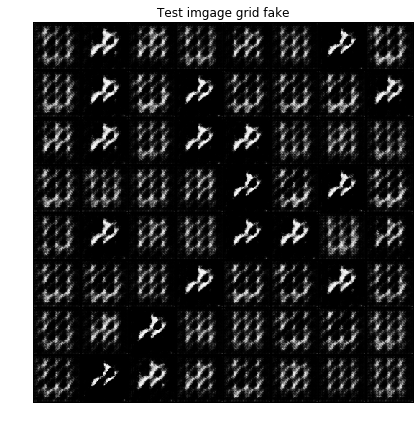

In [26]:
gen_model_pth = torch.load("gen_model.pth")
with torch.no_grad():
    test_fake = gen_model(fixed_noise)
    test_img_grid_fake = make_grid(test_fake[:64], normalize=True)

# Plot the real images
plt.figure(figsize=(15, 8))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Test imgage grid fake")
plt.imshow(np.transpose(test_img_grid_fake.to(device).cpu(), (1,2,0)))
plt.show()

## Generator & Discriminator loss during training

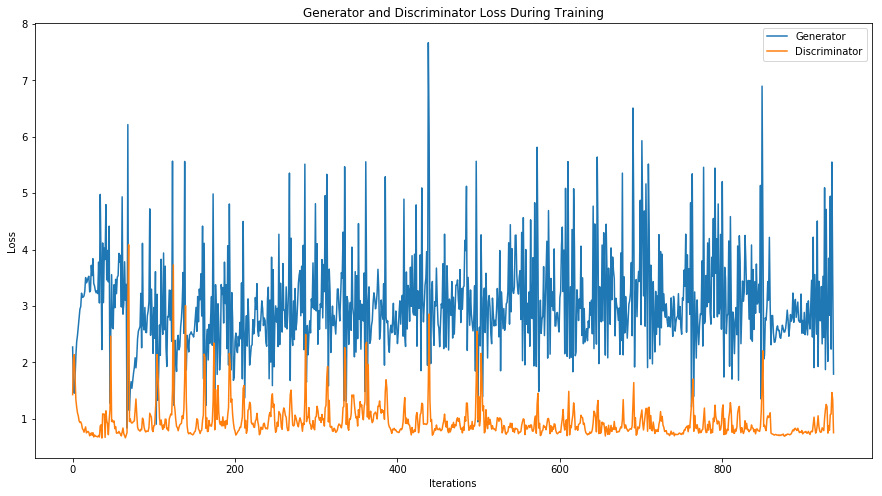

In [20]:
plt.figure(figsize=(15, 8))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(gen_train_loss, label="Generator")
plt.plot(dis_train_loss, label="Discriminator")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend(['Generator', 'Discriminator'])
plt.show()

## Plot the real & fake images

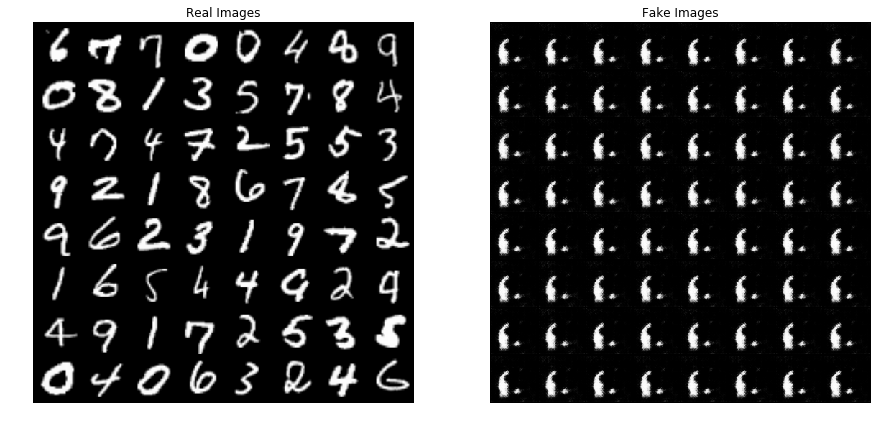

In [21]:
# Plot the real images
plt.figure(figsize=(15, 8))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
for real_img in real_imgs:
    plt.imshow(np.transpose(real_img.to(device).cpu(), (1,2,0)))
    
# Plot the fake images
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
for fake_img in fake_imgs:
    plt.imshow(np.transpose(fake_img.to(device).cpu(), (1,2,0)))
plt.show()